<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Analyze_TargetRegions_Grouping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Analyze_TargetRegions_Grouping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyze Target Regions & Group Participants by Stimulation Target

This notebook:
1. Loads the TMS-fMRI dataset
2. Extracts target regions for each subject's task-stim sessions
3. Groups participants by target region
4. Provides summary statistics on group sizes and target region distribution

In [1]:
# --- Setup cell (Google Colab compatibility) ---

import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive', force_remount=True)
    BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
except:
    IN_COLAB = False
    # Local path
    BASE = "/path/to/your/data"  # Update this if running locally

# Clone repo if needed
if IN_COLAB:
    repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
    if not os.path.exists(repo_dir):
        !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
    else:
        print("Repo already exists ✅")
    sys.path.append(repo_dir)

print(f"Running in Colab: {IN_COLAB}")
print(f"Data directory: {BASE}")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 554 (delta 87), reused 10 (delta 10), pack-reused 351 (from 2)
Receiving objects: 100% (554/554), 70.57 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Running in Colab: True
Data directory: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data


In [2]:
# --- Load dataset ---

DATASET_PKL = os.path.join(BASE, "TMS_fMRI", "dataset_tian50_schaefer400_allruns.pkl")

print(f"Loading dataset from: {DATASET_PKL}")
with open(DATASET_PKL, "rb") as f:
    dataset = pickle.load(f)

print(f"✅ Dataset loaded successfully")
print(f"Number of subjects: {len(dataset)}")
print(f"Sample subject keys: {list(dataset.keys())[:3]}")

Loading dataset from: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl


/tmp/ipython-input-3392984062.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset = pickle.load(f)


✅ Dataset loaded successfully
Number of subjects: 46
Sample subject keys: ['sub-NTHC1001', 'sub-NTHC1003', 'sub-NTHC1009']


In [3]:
# --- Extract subject list and explore structure ---

subjects_list = sorted([s.replace('sub-', '') for s in dataset.keys()])
print(f"Subjects: {subjects_list}")
print(f"Total subjects: {len(subjects_list)}")

# Check structure for first subject
first_subject = 'sub-' + subjects_list[0]
print(f"\nStructure for {first_subject}:")
print(f"  Conditions: {list(dataset[first_subject].keys())}")
print(f"  Task-rest trials: {len(dataset[first_subject].get('task-rest', []))}")
print(f"  Task-stim trials: {len(dataset[first_subject].get('task-stim', []))}")

Subjects: ['NTHC1001', 'NTHC1003', 'NTHC1009', 'NTHC1015', 'NTHC1016', 'NTHC1019', 'NTHC1021', 'NTHC1022', 'NTHC1023', 'NTHC1024', 'NTHC1026', 'NTHC1027', 'NTHC1028', 'NTHC1029', 'NTHC1032', 'NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1057', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1065', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1075', 'NTHC1097', 'NTHC1098', 'NTHC1099', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108']
Total subjects: 46

Structure for sub-NTHC1001:
  Conditions: ['task-rest', 'task-stim']
  Task-rest trials: 1
  Task-stim trials: 1


In [4]:
# --- Extract target regions for each subject ---

# Dictionary: subject_id -> list of target region IDs (from task-stim sessions)
subject_targets = {}

# Dictionary: target_region_id -> list of subject_ids
target_to_subjects = defaultdict(list)

# Track all unique target regions
all_target_regions = set()

for subject_id, subject_name in enumerate(subjects_list):
    full_subject_name = 'sub-' + subject_name

    # Get task-stim sessions for this subject
    task_stim_sessions = dataset[full_subject_name].get('task-stim', [])

    subject_targets[subject_id] = []

    # Extract target region from each task-stim session
    for trial in range(len(task_stim_sessions)):
        try:
            target_array = dataset[full_subject_name]['task-stim'][trial]['target']
            target_id = np.where(target_array == 1)[0][0]
            subject_targets[subject_id].append(target_id)
            all_target_regions.add(target_id)
            target_to_subjects[target_id].append(subject_id)
        except Exception as e:
            print(f"Error extracting target for {full_subject_name} trial {trial}: {e}")

print(f"✅ Target regions extracted")
print(f"\nTotal unique target regions: {len(all_target_regions)}")
print(f"Target region IDs: {sorted(all_target_regions)}")

✅ Target regions extracted

Total unique target regions: 11
Target region IDs: [np.int64(155), np.int64(220), np.int64(231), np.int64(305), np.int64(342), np.int64(359), np.int64(366), np.int64(386), np.int64(392), np.int64(401), np.int64(403)]


In [5]:
# --- Summary: targets per subject ---

print("\n" + "="*60)
print("TARGET REGIONS PER SUBJECT")
print("="*60)
for subject_id, subject_name in enumerate(subjects_list):
    targets = subject_targets[subject_id]
    unique_targets = set(targets)
    print(f"Subject {subject_id:2d} ({subject_name:3s}): {list(unique_targets)} (n_sessions={len(targets)})")


TARGET REGIONS PER SUBJECT
Subject  0 (NTHC1001): [np.int64(401)] (n_sessions=1)
Subject  1 (NTHC1003): [np.int64(342)] (n_sessions=1)
Subject  2 (NTHC1009): [np.int64(359), np.int64(231), np.int64(305), np.int64(401), np.int64(403), np.int64(155)] (n_sessions=6)
Subject  3 (NTHC1015): [np.int64(359), np.int64(392), np.int64(231), np.int64(366), np.int64(305), np.int64(401), np.int64(403), np.int64(342), np.int64(155)] (n_sessions=18)
Subject  4 (NTHC1016): [np.int64(359), np.int64(231), np.int64(366), np.int64(305), np.int64(401), np.int64(342), np.int64(155)] (n_sessions=7)
Subject  5 (NTHC1019): [np.int64(359), np.int64(392), np.int64(231), np.int64(366), np.int64(305), np.int64(401), np.int64(403), np.int64(342), np.int64(155)] (n_sessions=9)
Subject  6 (NTHC1021): [np.int64(359), np.int64(231), np.int64(366), np.int64(305), np.int64(401), np.int64(403), np.int64(155)] (n_sessions=7)
Subject  7 (NTHC1022): [np.int64(359), np.int64(392), np.int64(231), np.int64(366), np.int64(305),

In [6]:
# --- Summary: participants per target region ---

print("\n" + "="*60)
print("PARTICIPANTS PER TARGET REGION")
print("="*60)

# Create a clean summary
target_region_summary = {}
for target_id in sorted(all_target_regions):
    subject_ids = sorted(list(set(target_to_subjects[target_id])))  # unique subjects per target
    n_subjects = len(subject_ids)
    subject_names = [subjects_list[sid] for sid in subject_ids]
    target_region_summary[target_id] = {
        'subject_ids': subject_ids,
        'subject_names': subject_names,
        'n_subjects': n_subjects,
        'n_sessions': len(target_to_subjects[target_id])
    }
    print(f"Target region {target_id:3d}: {n_subjects} subjects {subject_names} ({len(target_to_subjects[target_id])} sessions total)")

print(f"\nTotal groups: {len(target_region_summary)}")


PARTICIPANTS PER TARGET REGION
Target region 155: 40 subjects ['NTHC1009', 'NTHC1015', 'NTHC1016', 'NTHC1019', 'NTHC1021', 'NTHC1022', 'NTHC1024', 'NTHC1026', 'NTHC1027', 'NTHC1028', 'NTHC1029', 'NTHC1032', 'NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1057', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1098', 'NTHC1099', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108'] (42 sessions total)
Target region 220: 27 subjects ['NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1065', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1098', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108'] (28 sessions total)
Target region 231: 42 subjects ['NTHC1009', 'NTHC1015', 'NTH

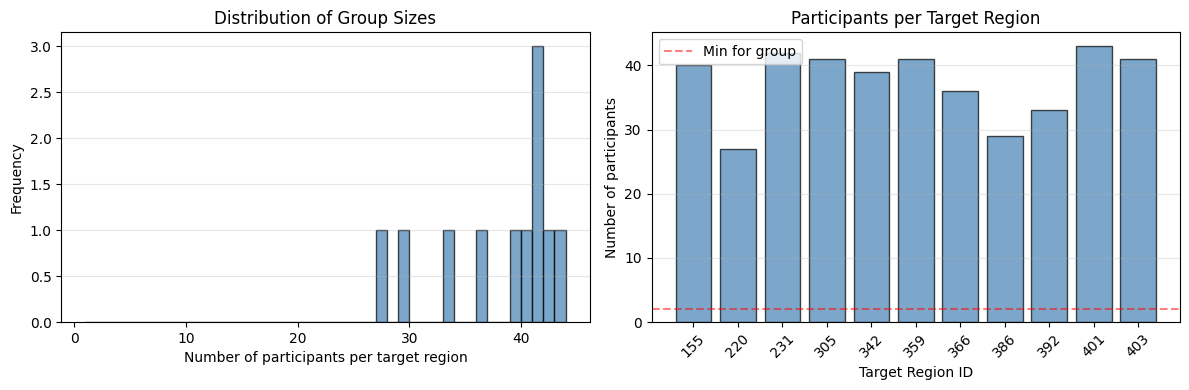


💡 Note: Blue bars = targets with ≥2 participants (can form groups)
           Red bars = targets with 1 participant (singleton groups)


In [7]:
# --- Visualization: Histogram of group sizes ---

group_sizes = [info['n_subjects'] for info in target_region_summary.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax1.hist(group_sizes, bins=range(1, max(group_sizes)+2), edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Number of participants per target region')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Group Sizes')
ax1.grid(axis='y', alpha=0.3)

# Bar plot: participants per target region
target_ids = sorted(target_region_summary.keys())
n_subjects_per_target = [target_region_summary[tid]['n_subjects'] for tid in target_ids]

colors = ['steelblue' if n >= 2 else 'lightcoral' for n in n_subjects_per_target]
ax2.bar(range(len(target_ids)), n_subjects_per_target, color=colors, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Target Region ID')
ax2.set_ylabel('Number of participants')
ax2.set_title('Participants per Target Region')
ax2.set_xticks(range(len(target_ids)))
ax2.set_xticklabels([str(tid) for tid in target_ids], rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=2, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Min for group')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n💡 Note: Blue bars = targets with ≥2 participants (can form groups)")
print(f"           Red bars = targets with 1 participant (singleton groups)")

In [8]:
# --- Statistical summary ---

group_sizes = np.array([info['n_subjects'] for info in target_region_summary.values()])

print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)
print(f"Total target regions: {len(target_region_summary)}")
print(f"Mean participants per group: {group_sizes.mean():.2f}")
print(f"Median participants per group: {np.median(group_sizes):.0f}")
print(f"Min participants per group: {group_sizes.min()}")
print(f"Max participants per group: {group_sizes.max()}")
print(f"\nGroups with ≥2 participants: {(group_sizes >= 2).sum()}")
print(f"Groups with 1 participant: {(group_sizes == 1).sum()}")
print(f"\nTotal participants to train: {(group_sizes >= 2).sum()} groups")
print(f"Participants in multi-subject groups: {group_sizes[group_sizes >= 2].sum()}")


STATISTICAL SUMMARY
Total target regions: 11
Mean participants per group: 37.45
Median participants per group: 40
Min participants per group: 27
Max participants per group: 43

Groups with ≥2 participants: 11
Groups with 1 participant: 0

Total participants to train: 11 groups
Participants in multi-subject groups: 412


In [9]:
# --- Create grouped participant list for downstream analysis ---

# Filter to only groups with ≥2 participants (ready for training)
multi_subject_groups = {target_id: info for target_id, info in target_region_summary.items() if info['n_subjects'] >= 2}

print(f"\n🎯 Multi-subject groups ready for training:")
print(f"="*60)
for target_id, info in sorted(multi_subject_groups.items()):
    print(f"Target {target_id}: {info['n_subjects']} participants {info['subject_names']}")

print(f"\n✅ Total trainable groups: {len(multi_subject_groups)}")


🎯 Multi-subject groups ready for training:
Target 155: 40 participants ['NTHC1009', 'NTHC1015', 'NTHC1016', 'NTHC1019', 'NTHC1021', 'NTHC1022', 'NTHC1024', 'NTHC1026', 'NTHC1027', 'NTHC1028', 'NTHC1029', 'NTHC1032', 'NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1057', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1098', 'NTHC1099', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108']
Target 220: 27 participants ['NTHC1035', 'NTHC1036', 'NTHC1037', 'NTHC1038', 'NTHC1039', 'NTHC1040', 'NTHC1043', 'NTHC1047', 'NTHC1049', 'NTHC1050', 'NTHC1052', 'NTHC1053', 'NTHC1055', 'NTHC1056', 'NTHC1061', 'NTHC1062', 'NTHC1064', 'NTHC1065', 'NTHC1066', 'NTHC1068', 'NTHC1073', 'NTHC1098', 'NTHC1101', 'NTHC1102', 'NTHC1105', 'NTHC1107', 'NTHC1108']
Target 231: 42 participants ['NTHC1009', 'NTHC1015', 'NTHC1016', 'NTHC1019', 'NTHC1021', 'NTHC

In [ ]:
# --- Optional: Save summary to pickle for downstream notebooks ---

summary = {
    'subjects_list': subjects_list,
    'subject_targets': subject_targets,
    'all_target_regions': sorted(list(all_target_regions)),
    'target_region_summary': target_region_summary,
    'multi_subject_groups': multi_subject_groups,
}

summary_pkl = os.path.join(BASE, "TMS_fMRI", "target_regions_grouping_summary.pkl")
with open(summary_pkl, "wb") as f:
    pickle.dump(summary, f)

print(f"💾 Saved grouping summary to: {summary_pkl}")